# pySCENIC protocol: 7seq data

June 2020

Dataset: 7seq from Dominic

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [32]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

#### set variables for file paths to read from and write to:

In [33]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/integrated_projects/7-seq_050120/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/integrated_projects/7-seq_050120'

In [34]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'output/scenic/Final_dataset_duplicate_070320-final.loom'

In [36]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

## Extract relevant data from the integrated loom file

In [37]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [38]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [39]:
thresholds

{'ATF4_(+)': 0.3430726229370814,
 'CEBPB_(+)': 0.02849711349208851,
 'CRX_(+)': 0.1583821205785506,
 'E2F1_(+)': 0.15586725422103484,
 'E2F3_(+)': 0.12282289213401663,
 'E2F7_(+)': 0.13258618583069157,
 'E2F8_(+)': 0.13453152290514303,
 'EGR2_(+)': 0.10267911227945359,
 'EGR3_(+)': 0.07730770847285716,
 'FOS_(+)': 0.14486483693649863,
 'FOXP4_(+)': 0.18586209478894175,
 'HMX1_(+)': 0.42816607915327753,
 'HSF1_(+)': 0.46008633450697645,
 'IKZF1_(+)': 0.05497477599664436,
 'IRF8_(+)': 0.3255625777348135,
 'ISL2_(+)': 0.3544197255366658,
 'JUN_(+)': 0.20670376665959295,
 'JUNB_(+)': 0.11365284867445043,
 'JUND_(+)': 0.12476422920052688,
 'KLF2_(+)': 0.036286610012047124,
 'KLF3_(+)': 0.09006349950387896,
 'KLF5_(+)': 0.0500094418787872,
 'KLF6_(+)': 0.17818497877563805,
 'LHX2_(+)': 0.39302692429849184,
 'LHX3_(+)': 0.674444766765502,
 'LHX9_(+)': 0.06272857319218987,
 'MAX_(+)': 0.18679469558404085,
 'MAZ_(+)': 0.1488043599714074,
 'MXI1_(+)': 0.369670584608589,
 'MYCN_(+)': 0.2992385884

In [7]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [8]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [9]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [10]:
myregulon = 'THRB_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

KeyError: 'THRB_(+)'

## distribution of number of genes per regulon

In [11]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count      47.000000
mean      169.085106
std       265.143262
min         3.000000
25%        14.000000
50%        34.000000
75%       190.000000
max      1027.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [12]:
adata = sc.read( f_final_loom, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [13]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [14]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [15]:
sc._utils.sanitize_anndata( adata )

... storing 'Abbrev_Groups' as categorical
... storing 'Cell_Type' as categorical
... storing 'ClusterID' as categorical
... storing 'Cluster_Color' as categorical
... storing 'Clusterings' as categorical
... storing 'Collection_Date' as categorical
... storing 'Collection_Gate' as categorical
... storing 'Collection_Method' as categorical
... storing 'Fetal_Age_seurat' as categorical
... storing 'HR_Cluster_Black' as categorical
... storing 'HR_Cluster_DG' as categorical
... storing 'HR_Cluster_LB' as categorical
... storing 'HR_Cluster_LG' as categorical
... storing 'Kit_ID' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'NRL_THRB_Regulon_Cluster' as categorical
... storing 'Non_Photoreceptors' as categorical
... storing 'Outliers' as categorical
... storing 'Phase' as categorical
... storing 'Possible_Rods' as categorical
... storing 'Retina_Region' as categorical
... storing 'Retina_and_Age' as categorical
... storing 'Rod_Cells' as categorical
... 

In [16]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [17]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [18]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [19]:
# df_motifs = load_motifs('reg.csv')

In [20]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [21]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [22]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


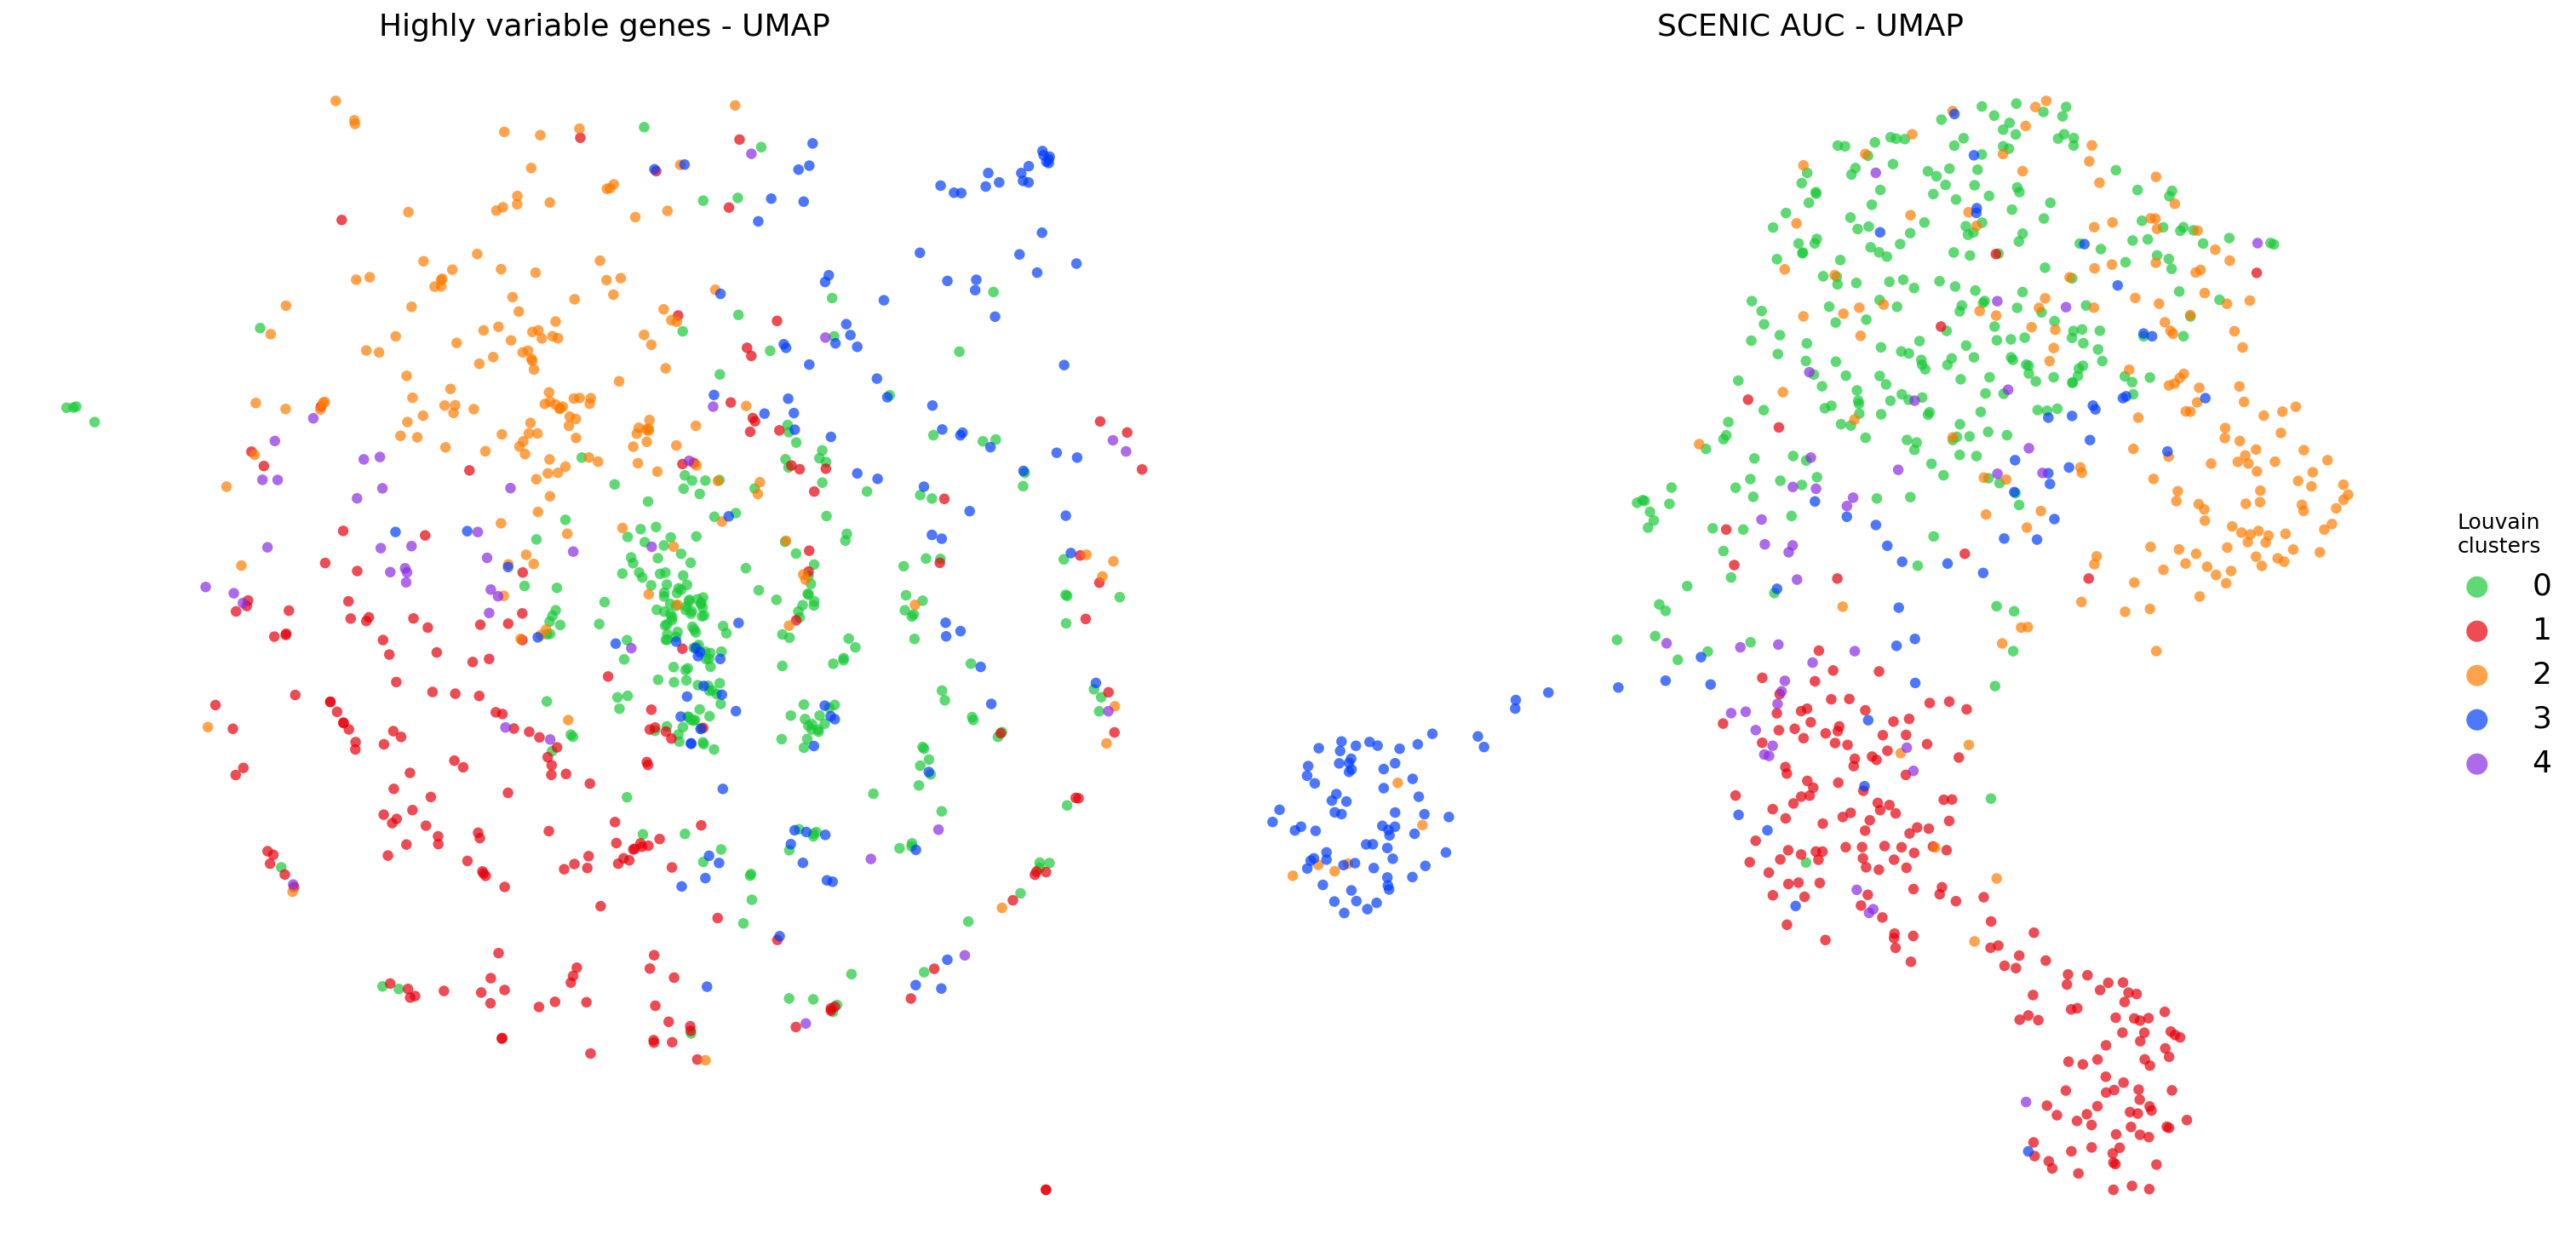

In [23]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [24]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [25]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [26]:
adata.obs.columns

Index(['Abbrev_Groups', 'Cell_Type', 'ClusterID', 'Cluster_Color',
       'Clusterings', 'Collection_Date', 'Collection_Gate', 'Collection_Group',
       'Collection_Method', 'Fetal_Age',
       ...
       'transcript_snn_res.0.2', 'transcript_snn_res.0.4',
       'transcript_snn_res.0.6', 'transcript_snn_res.0.8',
       'transcript_snn_res.1', 'transcript_snn_res.1.2',
       'transcript_snn_res.1.4', 'transcript_snn_res.1.6',
       'transcript_snn_res.1.8', 'transcript_snn_res.2'],
      dtype='object', length=124)

In [27]:
metavar="integrated_snn_res.1.6"

In [28]:
adata.obs


,Abbrev_Groups,Cell_Type,ClusterID,Cluster_Color,Clusterings,Collection_Date,Collection_Gate,Collection_Group,Collection_Method,Fetal_Age,...,transcript_snn_res.0.2,transcript_snn_res.0.4,transcript_snn_res.0.6,transcript_snn_res.0.8,transcript_snn_res.1,transcript_snn_res.1.2,transcript_snn_res.1.4,transcript_snn_res.1.6,transcript_snn_res.1.8,transcript_snn_res.2
ds20170407-442,ER,Immature Rods,1,NA,"(1,)",11/23/2016,NA,4.0,C1,15.0,...,0,1,1,1,1,1,1,0,0,0
ds20170407-443,iPRP,Progenitor/Rods,3,NA,"(3,)",11/23/2016,NA,4.0,C1,15.0,...,0,1,1,1,1,1,1,0,0,0
ds20170407-444,ER,Immature Rods,1,NA,"(1,)",11/23/2016,NA,4.0,C1,15.0,...,0,1,1,1,1,1,1,0,0,0
ds20170407-445,ER,Immature Rods,1,NA,"(1,)",11/23/2016,NA,4.0,C1,15.0,...,0,1,1,1,1,1,1,0,0,0
ds20170407-447,iPRP,Progenitor/Rods,3,NA,"(3,)",11/23/2016,NA,4.0,C1,15.0,...,0,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hs20151130-SC3-86,ER,Progenitor/Rods,2,NA,"(2,)",NA,NA,3.0,C1,13.0,...,0,1,1,1,1,1,1,0,0,0
hs20151130-SC3-89,LM,LM Cones,2,NA,"(2,)",NA,NA,3.0,C1,13.0,...,0,0,0,0,0,0,0,7,8,6
hs20151130-SC3-9,LM,LM Cones,2,NA,"(2,)",NA,NA,3.0,C1,13.0,...,0,0,0,0,0,4,2,2,4,4
hs20151130-SC3-90,LM,Transition/Early Maturing Cones,2,NA,"(2,)",NA,NA,3.0,C1,13.0,...,0,0,0,0,0,2,3,6,6,7


### Calculate RSS

In [29]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

,ATF4_(+),CEBPB_(+),CRX_(+),E2F1_(+),E2F3_(+),E2F7_(+),E2F8_(+),EGR2_(+),EGR3_(+),FOS_(+),...,RXRG_(+),SOX2_(+),SOX9_(+),SP3_(+),SPI1_(+),STAT6_(+),TFDP1_(+),THAP11_(+),VSX2_(+),ZNF260_(+)
0,0.349769,0.240808,0.356828,0.328110,0.267158,0.321805,0.316192,0.287698,0.185096,0.342255,...,0.267743,0.324057,0.312297,0.330851,0.259901,0.333090,0.329901,0.353359,0.337615,0.333168
8,0.214523,0.233897,0.213229,0.219914,0.208152,0.220695,0.221137,0.221024,0.223133,0.212427,...,0.205919,0.226718,0.231787,0.224138,0.242192,0.221949,0.209766,0.213105,0.226116,0.217044
4,0.271529,0.184347,0.284840,0.257747,0.234264,0.255434,0.252271,0.232391,0.198239,0.273325,...,0.320619,0.249802,0.237203,0.253910,0.232408,0.247477,0.273981,0.266686,0.253280,0.239688
1,0.304079,0.219557,0.322643,0.290012,0.247060,0.289903,0.283308,0.252964,0.201904,0.307058,...,0.358745,0.282360,0.271592,0.291995,0.253283,0.283130,0.308711,0.302225,0.288691,0.263744
2,0.277112,0.224451,0.275241,0.276479,0.263412,0.275414,0.272598,0.249918,0.180338,0.277931,...,0.291342,0.278701,0.272403,0.278368,0.229964,0.309162,0.278966,0.279738,0.277309,0.267860
9,0.217812,0.305533,0.183823,0.260628,0.257630,0.261421,0.251658,0.325781,0.352350,0.221735,...,0.175923,0.293311,0.321446,0.247085,0.203780,0.233150,0.221303,0.222206,0.274514,0.209911
5,0.280447,0.193874,0.284479,0.243625,0.224919,0.241868,0.237223,0.229847,0.184453,0.264173,...,0.215849,0.237398,0.229438,0.245290,0.196003,0.202747,0.259200,0.256297,0.244266,0.268817
6,0.264264,0.191911,0.268844,0.249723,0.238772,0.242463,0.240463,0.222340,0.204411,0.267515,...,0.298803,0.239224,0.227915,0.251316,0.236576,0.245101,0.268610,0.260351,0.242063,0.227748
7,0.228218,0.393898,0.184617,0.303531,0.398812,0.330252,0.354552,0.379596,0.338395,0.237243,...,0.181219,0.310588,0.336953,0.266010,0.224237,0.263049,0.251977,0.238825,0.295900,0.243482
10,0.206883,0.181545,0.212522,0.201022,0.206790,0.201220,0.203250,0.196467,0.186808,0.206595,...,0.200600,0.198742,0.197381,0.205070,0.184354,0.201065,0.206894,0.205494,0.200089,0.199097


In [30]:
rss_louvain.to_csv(r'/dataVolume/storage/single_cell_projects/integrated_projects/7-seq_050120/src/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

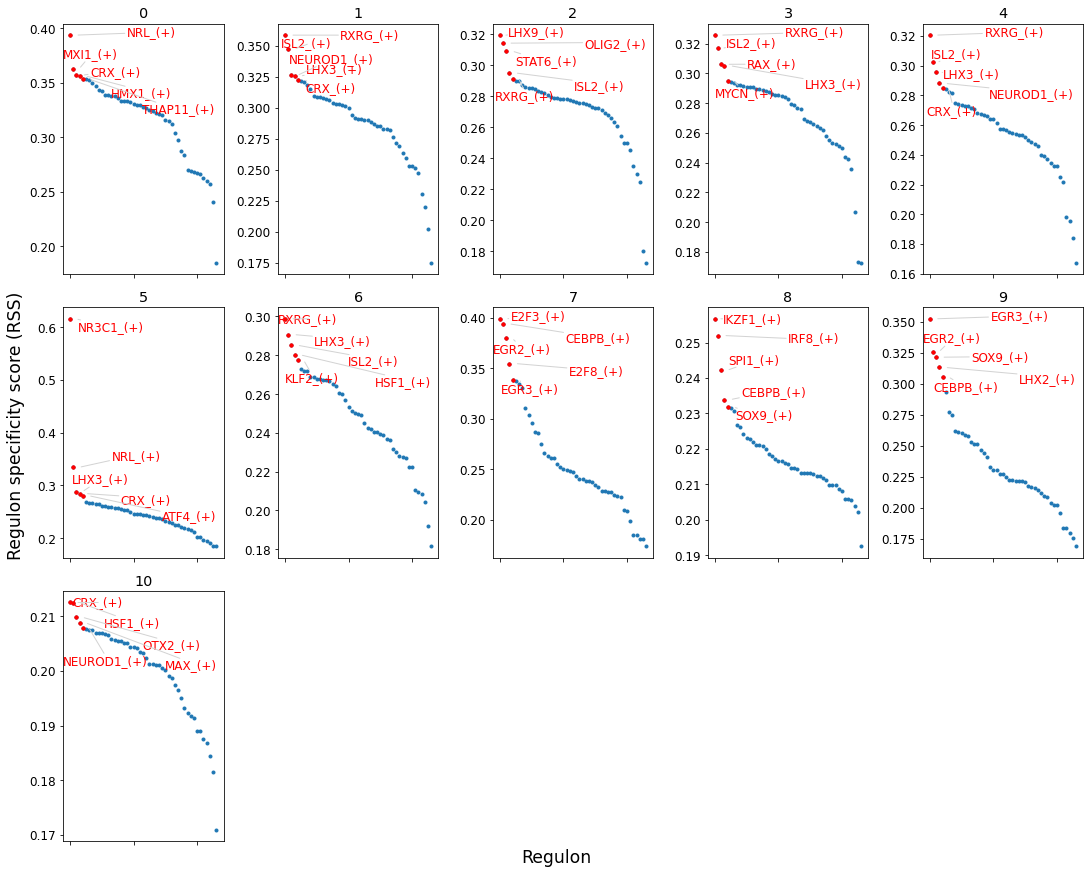

In [31]:
cats = sorted( list(set(cellAnnot[metavar])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [29]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [30]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby("integrated_snn_res.1.6")[topreg].mean()
mean_regulon_by_meta

,EGR3_(+),MXD3_(+),OTX2_(+),CUX1_(+),NR2F6_(+),IKZF1_(+),ATF4_(+),PAX6_(+),OLIG2_(+),EGR2_(+),...,ZBTB7A_(+),VEZF1_(+),E2F2_(+),SOX9_(+),HMX1_(+),NRL_(+),E2F3_(+),THRB_(+),CEBPB_(+),HSF1_(+)
integrated_snn_res.1.6,,,,,,,,,,,,,,,,,,,,,
0,0.003544,0.315464,0.235096,0.078236,0.211458,0.009889,0.209205,0.030812,0.031844,0.016427,...,0.115916,0.231636,0.014105,0.048997,0.261007,0.429427,0.012646,0.140156,0.007313,0.234097
1,0.003886,0.345521,0.235167,0.065452,0.239970,0.010119,0.179168,0.022229,0.039880,0.015837,...,0.095857,0.175636,0.010184,0.038678,0.223162,0.155711,0.008743,0.471389,0.005781,0.245975
2,0.003102,0.319795,0.224323,0.070477,0.189180,0.010720,0.183306,0.045978,0.102442,0.017208,...,0.081818,0.220104,0.017526,0.054443,0.270459,0.152799,0.015511,0.329441,0.009371,0.240347
3,0.001352,0.482502,0.258385,0.071096,0.297700,0.010314,0.212790,0.032070,0.058283,0.020075,...,0.086445,0.182135,0.011960,0.042283,0.275002,0.174499,0.010517,0.468232,0.010281,0.343272
4,0.001403,0.414150,0.247057,0.069541,0.269126,0.010344,0.190665,0.016566,0.024918,0.018380,...,0.094950,0.151668,0.009080,0.035812,0.209489,0.163473,0.009422,0.517207,0.004253,0.294933
5,0.002065,0.372602,0.268831,0.083543,0.311122,0.008442,0.258968,0.021262,0.012307,0.020383,...,0.112827,0.251104,0.007329,0.042353,0.175940,0.655946,0.010295,0.143235,0.004141,0.291681
6,0.001542,0.566527,0.280391,0.063795,0.314332,0.009260,0.230823,0.024236,0.045692,0.019017,...,0.085354,0.182957,0.006683,0.038549,0.243153,0.195822,0.011522,0.512361,0.006808,0.403573
7,0.040278,0.316117,0.133983,0.050919,0.084032,0.017569,0.185545,0.367107,0.069440,0.114489,...,0.043954,0.129295,0.253696,0.205364,0.393523,0.136476,0.152664,0.025719,0.075156,0.225215
8,0.022438,0.215041,0.161834,0.061011,0.139882,0.027601,0.145006,0.075111,0.072215,0.021127,...,0.082344,0.178954,0.023665,0.066014,0.213781,0.198710,0.019743,0.171557,0.012410,0.134157


#### Generate a Z-score for each regulon to enable comparison between regulons

In [31]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [32]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [33]:
cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['ds20170407-442', 'ds20171031_034', 'ds20171031_035', 'ds20171031_037',
       'shl20190501-643', 'ds20171031_097', 'shl20190501-641',
       'ds20171031_102', 'ds20171031_105', 'ds20171031_106',
       ...
       'shl20190501-647', 'ds20171031_203', 'shl20190501-640',
       'hs20151130-SC3-62', 'ds20181001-1065', 'ds20171031_216',
       'ds20171031_145', 'ds20181001-0339', 'shl20190501-660',
       '20200312-DS-dissected-37'],
      dtype='object', length=794)

In [34]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [35]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar] ]

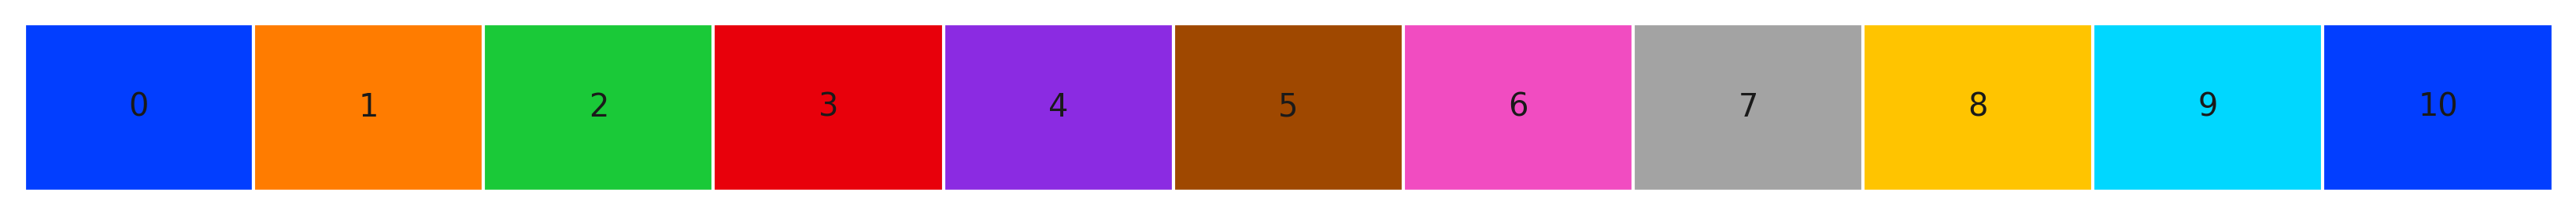

In [36]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -142.80833333333342, '')

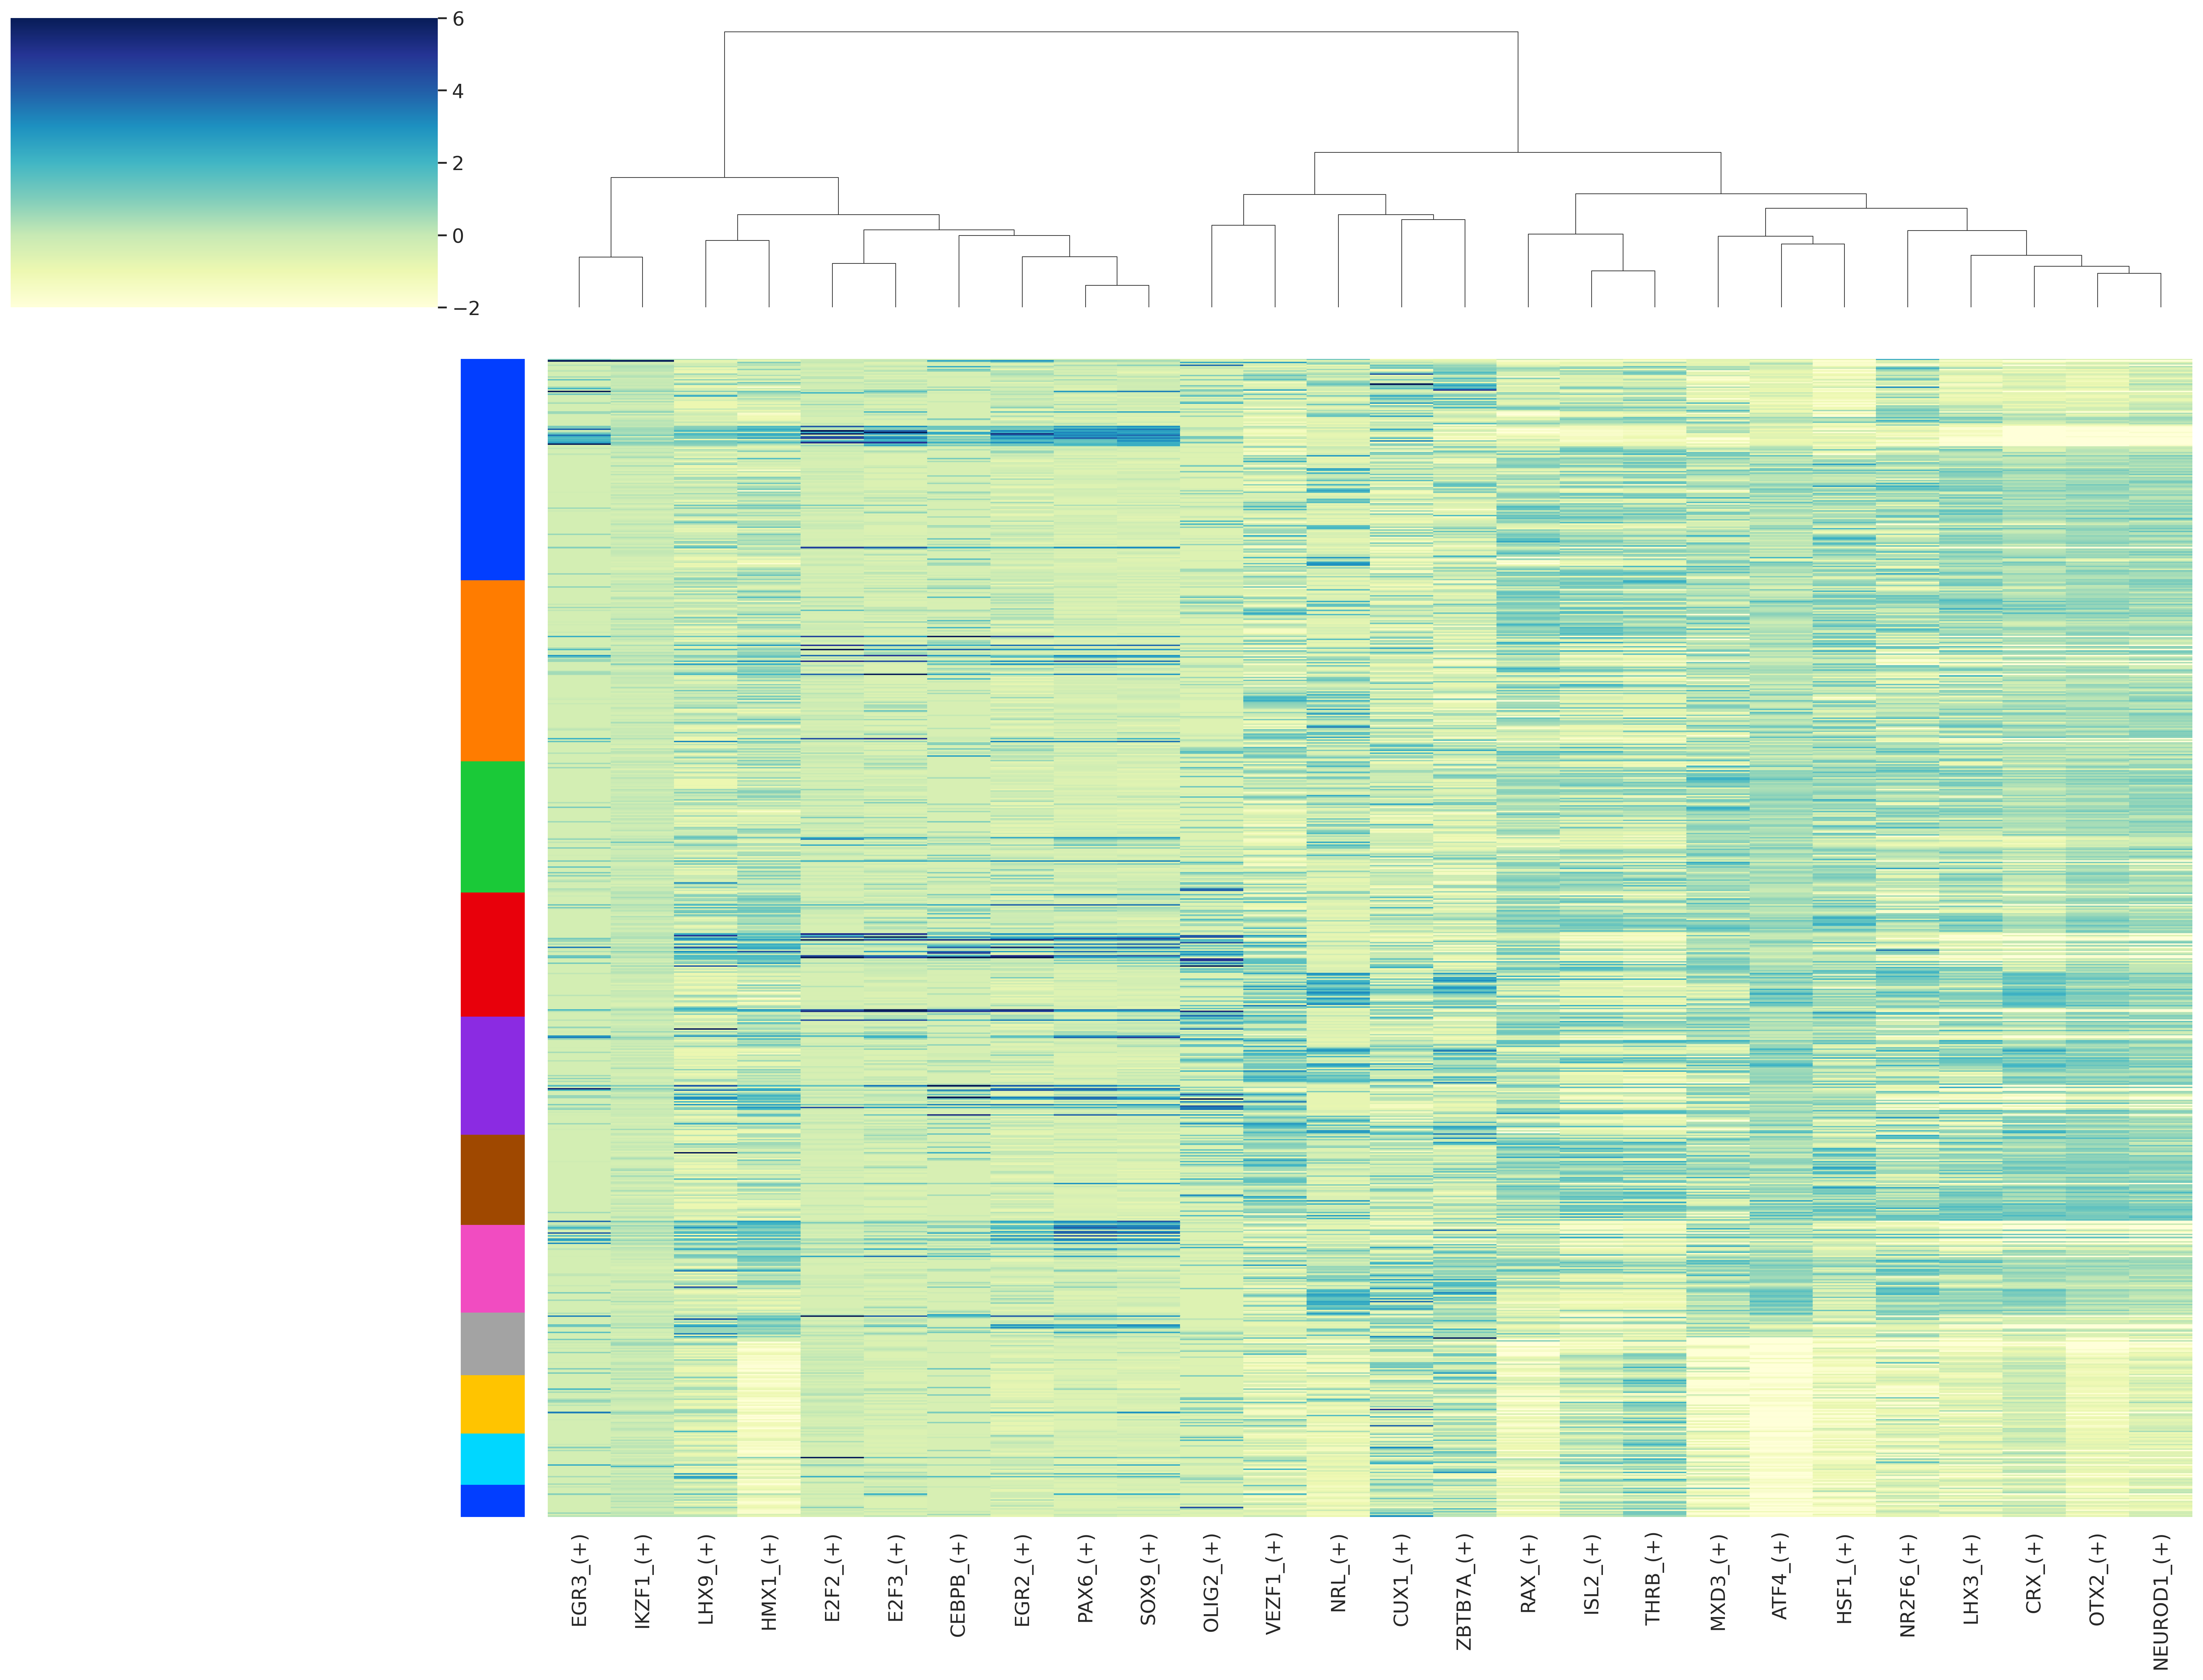

In [37]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [38]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [39]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000015


In [40]:
# binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
# binary_mtx.head()

### Show the AUC distributions for selected regulons

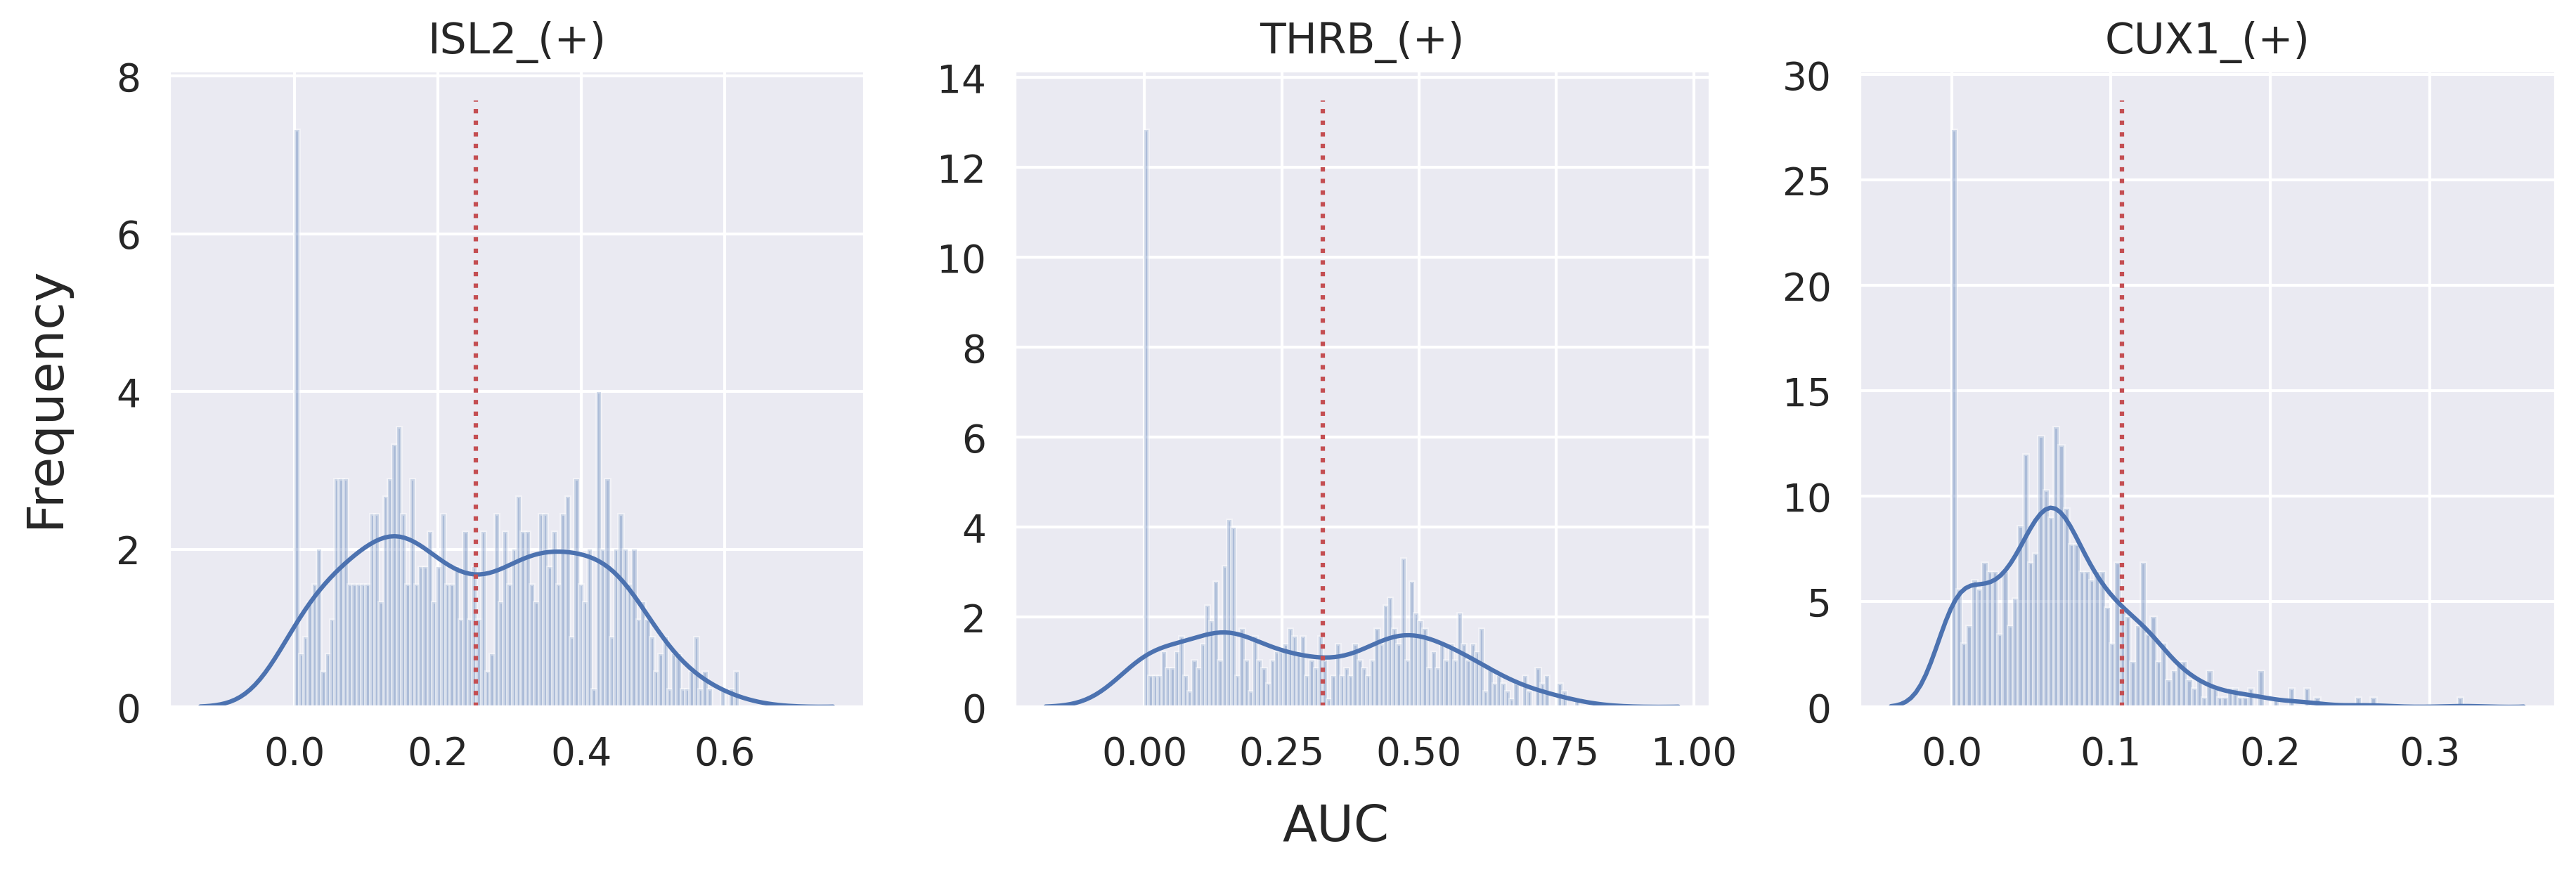

In [41]:
# select regulons:
r = [ 'ISL2_(+)', 'THRB_(+)', 'CUX1_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

# Further exploration of modules directly from the network inference output

In [42]:
# adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

Create the modules:

In [43]:
# from pyscenic.utils import modules_from_adjacencies
# modules = list(modules_from_adjacencies(adjacencies, exprMat))

#### pick out modules for EBF1:

In [44]:
# tf = 'EBF1'
# tf_mods = [ x for x in modules if x.transcription_factor==tf ]

# for i,mod in enumerate( tf_mods ):
#     print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
# print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

write these modules, and the regulon to files:

In [45]:
# for i,mod in enumerate( tf_mods ):
#     with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
#         for item in mod.genes:
#             f.write("%s\n" % item)
            
# with open( tf+'_regulon.txt', 'w') as f:
#     for item in regulons[tf+'_(+)']:
#         f.write("%s\n" % item)

# display regulon scores on umap

In [46]:
# read seurat object
import scanpy as sc
adata = sc.read_h5ad("output/scanpy/Final_dataset_duplicate_070320.h5ad")

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


In [47]:
auc_mtx.index = auc_mtx.index.str.replace("ds20170407_S", "ds20170407-")

In [48]:
adata.obs[auc_mtx.columns] = auc_mtx

In [49]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Sample_ID,batch,Kit_ID,Seq_Number,X5,Poor_Read_Number,Moderate_Alignment,...,SOX2_(+),SOX9_(+),SP3_(+),SPI1_(+),TFDP1_(+),THAP11_(+),THRB_(+),VEZF1_(+),VSX2_(+),ZBTB7A_(+)
ds20170407-442,ds20170407,1.873634e+06,5578.0,ds20170407_S442,20170407-DS-C1-Hs,C1,1.0,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ds20170407-443,ds20170407,1.012991e+06,6003.0,ds20170407_S443,20170407-DS-C1-Hs,C1,1.0,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ds20170407-444,ds20170407,2.598136e+06,6789.0,ds20170407_S444,20170407-DS-C1-Hs,C1,1.0,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ds20170407-445,ds20170407,2.638103e+06,6043.0,ds20170407_S445,20170407-DS-C1-Hs,C1,1.0,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ds20170407-447,ds20170407,2.414070e+06,5549.0,ds20170407_S447,20170407-DS-C1-Hs,C1,1.0,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hs20151130-SC3-86,hs20151130,6.787668e+05,4360.0,NA,20151130-HS-C1-Hs,NA,NaN,2,2,2,...,0.063992,0.061566,0.009508,0.000000,0.077047,0.041200,0.000000,0.138737,0.062869,0.078370
hs20151130-SC3-89,hs20151130,5.020281e+05,5019.0,NA,20151130-HS-C1-Hs,NA,NaN,2,2,2,...,0.040724,0.036707,0.013659,0.000000,0.096039,0.052309,0.547544,0.140618,0.046317,0.152958
hs20151130-SC3-9,hs20151130,9.205718e+05,7875.0,NA,20151130-HS-C1-Hs,NA,NaN,2,2,2,...,0.056835,0.033386,0.000000,0.000000,0.072638,0.059872,0.562099,0.091178,0.054021,0.091581
hs20151130-SC3-90,hs20151130,1.146995e+06,5864.0,NA,20151130-HS-C1-Hs,NA,NaN,2,2,2,...,0.071108,0.055638,0.022529,0.000000,0.124183,0.061875,0.527691,0.090909,0.078803,0.109345


In [51]:
mean_regulon_by_meta.loc[:,"NRL_(+)"]

integrated_snn_res.1.6
0     0.429427
1     0.155711
2     0.152799
3     0.174499
4     0.163473
5     0.655946
6     0.195822
7     0.136476
8     0.198710
9     0.134701
10    0.195068
Name: NRL_(+), dtype: float64

In [ ]:
sc.pl.umap(adata, color=auc_mtx.columns, size=60, save='.pdf')